In [4]:
from torchvision import models, transforms, datasets
import torch
from torch import nn
# from utils import *
from model import *
import matplotlib.pyplot as plt

/home/rich_tang/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rich_tang/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
train_data_path = '/mnt/c/Dataset/asl-test-ir/train/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
train_transforms = transforms.Compose([
    # transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    # transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [7]:
%%time
train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)

CPU times: user 36.6 ms, sys: 3.27 ms, total: 39.8 ms
Wall time: 394 ms


In [8]:
%%time
val_dataset = datasets.ImageFolder(train_data_path, transform=test_transforms)

CPU times: user 8.21 ms, sys: 23.1 ms, total: 31.3 ms
Wall time: 238 ms


In [9]:
from time import time
torch.manual_seed(time())
num_train_samples = len(train_dataset)
# num_train_samples = 20000

val_split = 0.2
split = int(num_train_samples * val_split)
indices = torch.randperm(num_train_samples)


train_subset = torch.utils.data.Subset(train_dataset, indices[split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[:split])

len(train_subset), len(val_subset)

(10862, 2715)

In [10]:
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=16
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=4,
    shuffle=False,
    pin_memory=True,
    num_workers=16
)

In [13]:
classes = train_dataloader.dataset.dataset.classes

torch.Size([64, 1, 24, 32]) torch.Size([64])
Ground Truth X
torch.Size([1, 24, 32])
torch.Size([24, 32, 1])


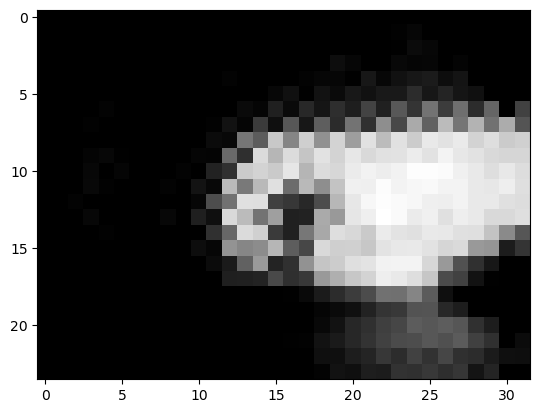

In [14]:
for img, label in train_dataloader:
    print(img.shape, label.shape)
    print(f'Ground Truth {classes[label[0]]}')
    print(img[0].size())
    print(img[0].permute(1, 2, 0).size())
    plt.imshow(img[0].permute(1, 2, 0),cmap='gray')
    break

In [ ]:
model= myCNN_24().to(device)
#model = torch.load('checkpoints/checkpoint_97.74.pth', map_location='cpu').to(device)
print(model)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")

In [ ]:
model.eval()

def full_inference(model, test_loader):
    correct = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for i, (data, target) in enumerate(test_loader, 1):
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print('\nTest set: Full Model Accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

full_inference(model, val_dataloader)


In [ ]:
from tqdm import tqdm

def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        # correct_val, total_val, val_loss = 0, 0, 0
        
        #model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)
            images_copy = images.clone().detach()

            # Forward pass
            
            output = model(images_copy)
            loss = criterion(output, labels)
            
            correct_train += (torch.max(output, dim=1)[1] == labels).type(torch.float).sum().item()
            total_train += labels.size(0)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.5f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.5f}.', end=' ')
                with torch.no_grad():
                    # model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).type(torch.float).sum().item()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.5f}. Val acc {correct_val / total_val * 100:.5f}.', end=' ')
                print(f'Took {time() - iter_time:.5f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)
        scheduler.step(val_loss / len(test_dataloader))
        torch.save(model, f'checkpoints-ir/checkpoint_{correct_val / total_val * 100:.2f}.pth')

        print(f'Epoch took {time() - start_time}') 
        
    return model, train_losses, val_losses

In [ ]:
print_every = 50
num_epoch = 30
#model = torch.load("checkpoints/checkpoint_85.68.pth", map_location='cpu')
#model = model.to(device)

model, train_losses, val_losses = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=print_every,
    num_epoch=num_epoch
)

In [ ]:
import numpy as np
train_losses_array=np.array(train_losses)
val_losses_array=np.array(val_losses)
np.save('train_losses_array-ir.npy',train_losses_array) 
np.save('val_losses_array-ir.npy',val_losses_array) 
# np.save('train_losses_array.txt','w',train_losses) 
# np.save('val_losses_array.txt','w',val_losses) 

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [2]:
from pathlib import Path
from PIL import Image
import torch


test_data_path = Path('/mnt/c/Dataset/asl-test-ir/test/')


class ASLTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None):
        super().__init__()
        
        self.transforms = transforms
        self.imgs = sorted(list(Path(root_path).glob('*.png')))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('L')
        
        label = img_path.parts[-1].split('_')[0]
        if self.transforms:
            img = self.transforms(img)
        
        return img, label

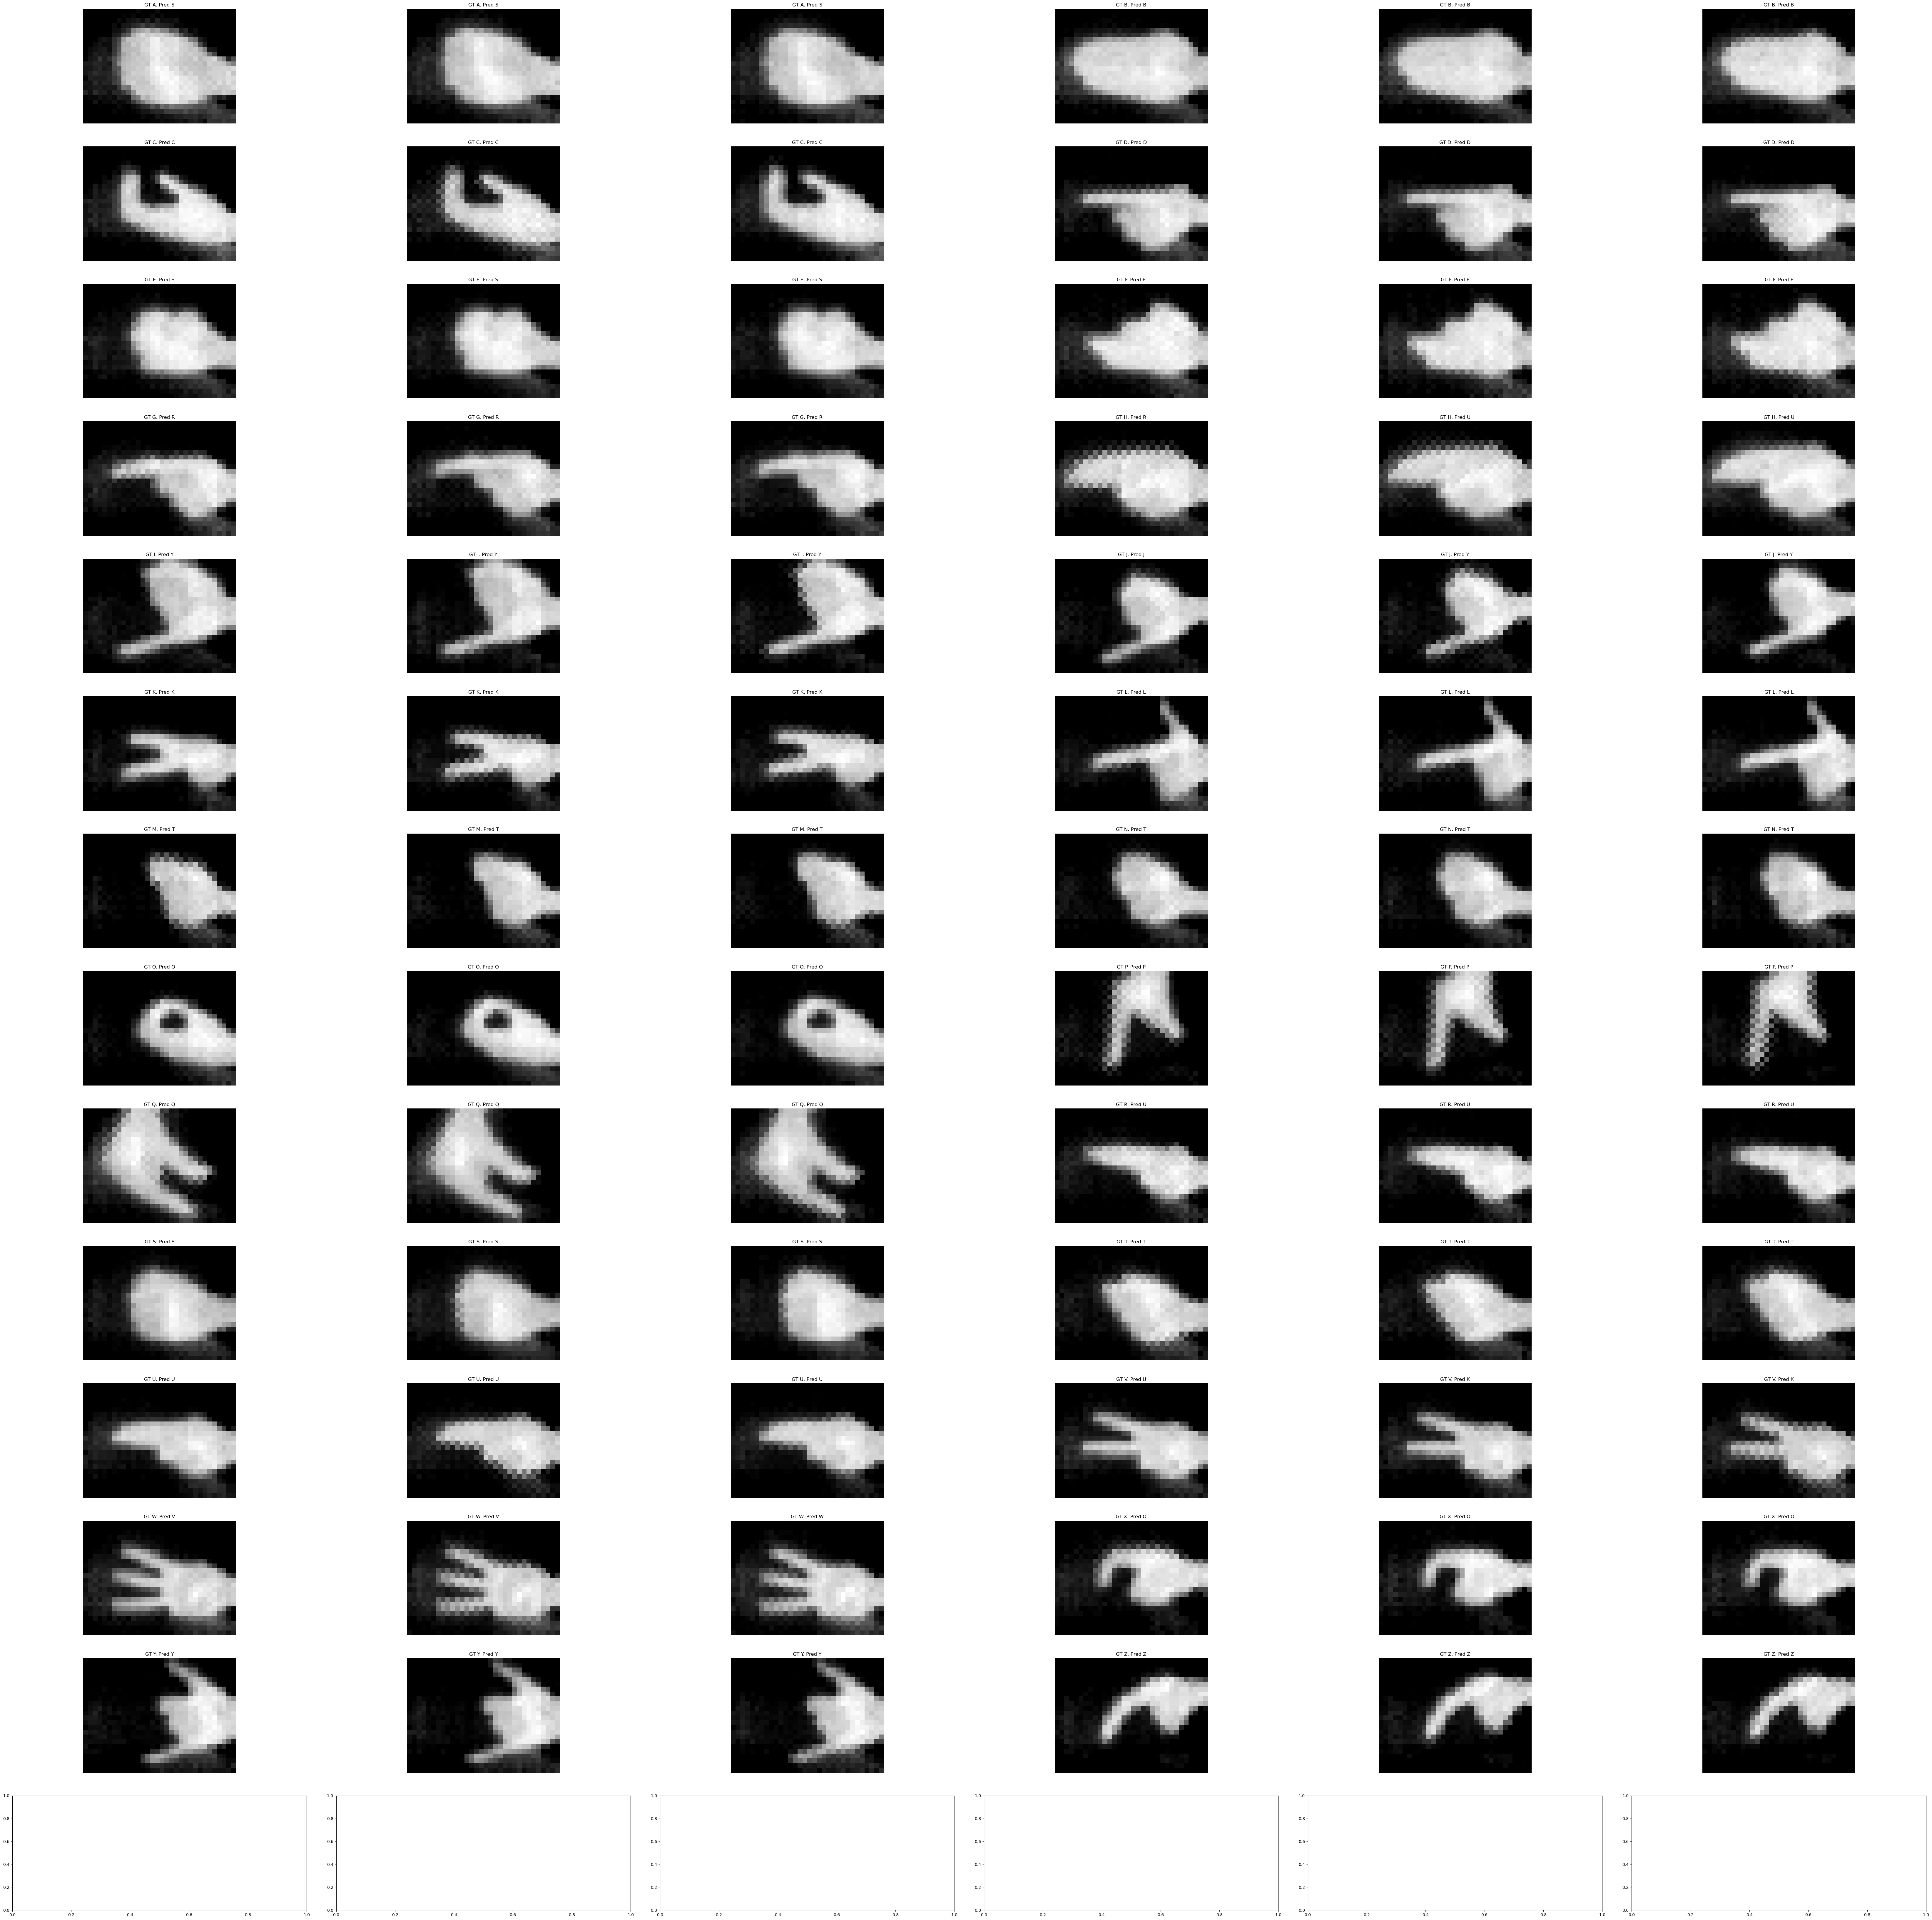

In [15]:
test_dataset = ASLTestDataset(test_data_path, transforms=test_transforms)
#test_dataset = val_subset

columns = 6
row = round(len(test_dataset) / columns) + 1

fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

test_model = torch.load("checkpoints-ir/checkpoint_97.05.pth", map_location='cpu')
# test_model = model
test_model.to(device)

i, j = 0, 0
for img, label in test_dataset:
    img = torch.Tensor(img)
    img = img.to(device)
    test_model.eval()
    prediction = test_model(img[None])

    ax[i][j].imshow(img.cpu().permute(1, 2, 0),cmap='gray')
    ax[i][j].set_title(f'GT {label}. Pred {classes[torch.max(prediction, dim=1)[1]]}') #torch.max(prediction, dim=1)[1]
    ax[i][j].axis('off')
    j += 1
    if j == columns:
        j = 0
        i += 1
        
plt.show()